<h1>
<center>CFRM 421/521, Spring 2022</center>
</h1>

<h1>
<center>Daniel Eduardo Oliver</center>
</h1>

<h1>
<center>Homework 1</center>
</h1>

* **Due: Monday, April 18, 2022, 11:59 PM**


* Total marks: 46


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as one Jupyter notebook.** The notebook must be already run, that is, make sure that you have run all your code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Preprocessing housing data [7 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

Consider the California housing data from Chapter 2 of the textbook. The following code fetches the data.

In [10]:
import os
import tarfile
from six.moves import urllib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_url, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

HOUSING_URL = ("https://raw.githubusercontent.com/ageron/"+
               "handson-ml2/master/datasets/housing/housing.tgz")
fetch_housing_data(HOUSING_URL)
data = load_housing_data()



Next, we create stratified test and training sets based on different income categories.

In [11]:
data["income_cat"] = np.ceil(data["median_income"] / 1.5)
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
    
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Let us separate the features (`X_raw`) and the response variable (`y`).

In [12]:
X_raw = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()

## (a) Handling missing values [1 mark]

Let us find out if there are any missing values in our features. As the code below indicates, out of 16512 observations, 158 have missing values. Further inspection shows that `total_bedrooms` has missing values (only a few missing values are shown below).

In [13]:
X_raw.shape

(16512, 9)

In [14]:
X_raw[X_raw.isnull().any(axis=1)].shape

(158, 9)

In [15]:
X_raw[X_raw.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


**Task:** Read the subsection "Data Cleaning" in Chapter 2 of the textbook. Use the `sklearn.impute.SimpleImputer` class to fill the missing values in the numerical features (everything except `ocean_proximity`) with the median of the corresponding feature.


**[Add your solution here]**

In [16]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = X_raw.drop("ocean_proximity", axis=1) #creates a copy of all the numerical features (drops the text feature)
imputer.fit(housing_num) 

imputer.statistics_

H = imputer.transform(housing_num)

housing_tr = pd.DataFrame(H, columns=housing_num.columns,index=housing_num.index)
housing_tr[housing_tr.isnull().any(axis=1)].shape


(0, 8)

## (b) Handling categorical features  [2 marks]
ML algorithms generally work with numerical values. So, we need to convert categorical features to numerical values. One way is to simply map each category to an integer. Another alternative is to use **one-hot encoding**.

**Task:** Read subsection "Handling Text and Categorical Attributes" in Chapter 2 of the textbook. Then use the `sklearn.preprocessing.OrdinalEncoder` class and the `sklearn.preprocessing.OneHotEncoder` class to transform the `ocean_proximity` feature to integers and one-hot vectors. Explain why it is more appropriate to use one-hot encoding.

**[Add your solution here]**

In [17]:
#page 66
from sklearn.preprocessing import OrdinalEncoder
housing_cat = X_raw[["ocean_proximity"]]
housing_cat.head(10)

#here we convert the categorical text to ordinal numbers
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

#the order of the categories is the following, 
ordinal_encoder.categories_

#pg 67
#here we do One Hot Encoding
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot #our onehotencoding is in a SciPy Sparse Matrix, since most values will be zero unless they are a 1 (bc they belong to one of the categories). Each instance has a category that they are a part of.

#here are the onehot encoding categories.
cat_encoder.categories_

print("The problem with ordinal encoding is that ML algo's assume that two nearby values are more similar than two distant values. One-Hot encoding is more approriate because it assigns a binary attribute to each category andwhich forms an 'identity vector' in which most of the values are zero and there is only one 1 per vector, which represents the category that the instance belongs to. This solves any ordinal confusion in the ML algo.")

The problem with ordinal encoding is that ML algo's assume that two nearby values are more similar than two distant values. One-Hot encoding is more approriate because it assigns a binary attribute to each category andwhich forms an 'identity vector' in which most of the values are zero and there is only one 1 per vector, which represents the category that the instance belongs to. This solves any ordinal confusion in the ML algo.


## (c) Feature scaling [2 marks]

Many ML algorithms do not perform well if the features have different scales (some very small, and others very large). In such scenarios, one should transform the features so that they have similar range of values. There are two common ways to achieve this. In **min-max** scaling, we subtract the feature from its minimum value and then divide by its range (i.e. maximum value minus minimum value) so that the scaled values are between 0 and 1. In **standardization**, we subtract the values from the average and divide by the standard deviation, so that the transformed values has mean 0 and variance 1.

**Task:** Read the subsection "Feature Scaling" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.MinMaxScaler` class and `sklearn.preprocessing.StandardScaler` class to scale the numerical features using min-max scaling and standardization.


**[Add your solution here]**

In [18]:
#pg 69
#Min_max scaling
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()

housing_num_mm = min_max.fit_transform(housing_num)

#pg 69
#Standardization
from sklearn.preprocessing import StandardScaler
standard = StandardScaler()

housing_num_ss = standard.fit_transform(housing_num)

## (d) Transformation pipelines [2 marks]

Usually, we have to perform several steps before the data is ready to be fed to an ML algorithm. Scikit-Learn's `Pipeline` class provides a systematic way of "packaging" such a sequence of transformations.

**Task:** Read the subsection "Transformation Pipelines" in Chapter 2 of the textbook. Then, create one pipeline that applies the transformations on part (a), (b) (use one-hot encoding), and (c) (use standardization) to the "raw" features `X_raw`. Call your transformed data `X`.



```
`# This is formatted as code`
```

**[Add your solution here]**

In [19]:
#pg 70
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy="median")),
                         ('std_scaler',StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num) #we don't need this for the final product

#We want to implement the pipeline transformation on both the numerical and categorical columns
#pg 71

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num) #this is just the name of the numerical columns that we are feeding in
cat_attribs = ["ocean_proximity"] #we just have to feed in the name of the categorical columns

full_pipeline = ColumnTransformer([
                                 ("num", num_pipeline, num_attribs),
                                 ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(X_raw)

# 2. Fine-tuning models [16 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

## (a) Linear regression [2 marks]

**Task:** Use the `sklearn.linear_model.LinearRegression` class to fit a linear regression to the training set in Question 1. Use the processed features `X` that you obtained in 1(d) as predictors and `y` (the median house values) as the response. Return fitted values of the response for the first 10 observations of the training set.

**[Add your solution here]**

In [20]:
#pg 72
from sklearn.linear_model import LinearRegression

housing_labels = y #these are the median house values

#trains a model (fits a model)
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

#return fitted values of the response for the first 10 observations of the training set
some_data = X_raw.iloc[:10] #.iloc[] is used when there isn't a visible integer index in the pandas dataframe, so we use the IMPLIED (not visible) row numbers instead
some_labels = housing_labels.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [211574.39523833 321345.10513719 210947.519838    61921.01197837
 192362.32961119 154821.86099031 426129.59146334 229666.3616775
 141483.54356476  12084.19502002]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0, 127900.0, 500001.0, 140200.0, 95000.0, 500001.0]


## (b) RMSE and MAE  [2 marks]

We can measure the out-of-sample performance with root mean square error (RMSE) and mean absolute error (MAE). 

**Task:** Use `mean_squared_error` and `mean_absolute_error` functions from `sklearn.metrics` to calculate the in-sample RMSE and MAE of the linear regression that you fit in part (a).

**[Add your solution here]**

In [21]:
#pg 72
from sklearn.metrics import mean_squared_error, mean_absolute_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(housing_labels, housing_predictions)

print(lin_rmse)
print(lin_mae)

69050.98178244587
49906.941422232885


## (c) Cross validation  [3 marks]

In part (b), we evaluated the in-sample performance of the linear regression model. To obtain out-of-sample performance, we use K-fold cross validation.

**Task:** Use the `cross_val_score` function from `sklearn.model_selection` to perform 10-fold  cross validation on the linear regression from part (a) and return the values of **RMSE**. Return the 10 RMSE scores as well as their mean.

**[Add your solution here]**

In [22]:
from sklearn.model_selection import cross_val_score
#pg 73, we are going to take a step back and break up the training set into 10 folds, we will then train the model on 9 folds and run on the remaining one fold, we do this ten times with the different combinations of folds. 
#the result will be 10 evaluation scores
#this returns the out-of-sample RMSE from the validation set. The target values in the validation set are necessary for finding the RMSE of our preditions.

scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

display_scores(lin_rmse_scores)

#we need to have run this cross-validation on more than one validation set or we wouldn't have produced a standard deviation measure.


Scores: [67450.42057782 67329.50264436 68361.84864912 74639.88837894
 68314.56738182 71628.61410355 65361.14176205 68571.62738037
 72476.18028894 68098.06828865]
Mean: 69223.18594556303
Standard deviation: 2657.268311277696


## (d) Alternatives to linear regression [3 marks]
Let us consider fitting two alternative models, namely, **decision trees** and **random forests**. These models will be discussed in future lectures. The following code fits a decision tree and obtains the fitted response for the first 10 observations.

In [23]:
from sklearn.tree import DecisionTreeRegressor #page 73
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(housing_prepared,housing_labels)

DecisionTreeRegressor(random_state=42)

In [24]:
dt_reg.predict(housing_prepared[:10,]) #i didn't worry about grabbing raw data and reprocessing it like in Q2b

array([286600., 340600., 196900.,  46300., 254500., 127900., 500001.,
       140200.,  95000., 500001.])

The following code does the same for the random forest model.

In [25]:
from sklearn.ensemble import RandomForestRegressor #pg 75

rf_reg = RandomForestRegressor(bootstrap=True, n_estimators=100, max_depth=5, random_state=42)
rf_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(max_depth=5, random_state=42)

In [26]:
rf_reg.predict(housing_prepared[:10,])


array([197897.38186239, 312857.05480804, 170838.26502119,  78919.95143337,
       213978.99963998, 127669.93984961, 454196.74104933, 204609.56439446,
       138451.98867262, 153166.14428368])

**Task:** Find the in-sample performance of the decision tree and the random forest using RMSE on the training set. Also, find the out-of-sample performance by 10-fold cross validation as you did in part (c). Which of the 3 models has the best in-sample performance? Which has the best out-of-sample performance?

**[Add your solution here]**

In [27]:
#pg 72
from sklearn.metrics import mean_squared_error, mean_absolute_error

housing_predictions_dt = dt_reg.predict(housing_prepared)
housing_predictions_rf =rf_reg.predict(housing_prepared)

dt_mse = mean_squared_error(housing_labels, housing_predictions_dt)
dt_rmse = np.sqrt(dt_mse)

rf_mse = mean_squared_error(housing_labels, housing_predictions_rf)
rf_rmse = np.sqrt(rf_mse)

print("Decision Tree in-sample RMSE")
print(dt_rmse)

print("\nRandom forest in-sample RMSE")
print(rf_rmse)

print("\nIn the in-sample test, the decision tree model outperfrms the random forest, the decision tree model produced no error (it is overfit).")

#now let's use k-fold cross-validation
from sklearn.model_selection import cross_val_score
#pg 73, we are going to take a step back and break up the training set into 10 folds, we will then train the model on 9 folds and run on the remaining one fold, we do this ten times with the different combinations of folds. 
#the result will be 10 evaluation scores
#this returns the out-of-sample RMSE from the validation set. The target values in the validation set are necessary for finding the RMSE of our preditions.

scores_dt = cross_val_score(dt_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error",cv=10)
dt_rmse_scores = np.sqrt(-scores_dt)

scores_rf = cross_val_score(rf_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error",cv=10)
rf_rmse_scores = np.sqrt(-scores_rf)

print("\nRandom forest has the best out of sample performance.")
print("Deicision Tree out-of-sample RMSE")
display_scores(dt_rmse_scores)
print("\nRandom forest out-of-sample RMSE")
display_scores(rf_rmse_scores)

print("\nRandom forest has the better out-of-sample RMSE.")


Decision Tree in-sample RMSE
0.0

Random forest in-sample RMSE
66680.31411841711

In the in-sample test, the decision tree model outperfrms the random forest, the decision tree model produced no error (it is overfit).

Random forest has the best out of sample performance.
Deicision Tree out-of-sample RMSE
Scores: [66757.2013883  66708.05413959 71135.77592971 69317.58307062
 68729.37098167 75649.34082791 67043.83260349 70251.84122452
 69273.49135944 69161.37598811]
Mean: 69402.78675133755
Standard deviation: 2512.0648514114073

Random forest out-of-sample RMSE
Scores: [65700.45624157 65412.32803475 67106.0935323  68745.76431365
 68377.99796777 72240.18920168 63778.47273911 67392.56263794
 71018.43990131 69008.50914107]
Mean: 67878.08137111469
Standard deviation: 2441.945310174933

Random forest has the better out-of-sample RMSE.


## (e) Choosing optimal values of hyperparameters using cross validation [4 marks]

Most ML algorithms have **hyperparameters**. These hyperparameters control the learning process and should not be confused with the model parameters (which are the unknown values that are being estimated). For example, the random forest algorithm has 3 hyperparameters, namely `bootstrap`, `n_estimators`, and `max_depth`. To fine-tune a model, we should find good values of the hyperparameters based on out-of-sample performance.

**Task:** Read the subsections "Grid Search" and "Randomized Search" in Chapter 2 of the textbook. Consider the random forest model with the argument `random_state=42`. Use the `sklearn.model_selection.GridSearchCV` class to choose the best hyperparameter values for `bootstrap` over the values `True`, `False`; `n_estimators` over the values 50, 100, 200; and `max_depth` over the values 5, 20, 40. Use 4-fold cross-validation with RMSE when searching for the hyperparameters.

Next, use the `sklearn.model_selection.RandomizedSearchCV` class to perform a randomized search over the same ranges with 18 parameter settings sampled, that is `bootstrap` is `True` or `False` with equal probability, `n_estimators` is a uniform random integer between 50 and 200, `max_depth` is a uniform random integer between 5 and 40. `RandomizedSearchCV` must include the argument `random_state=42`.

In both functions, you may use the argument `n_jobs=-1` to use all avaliable processor cores to speed up the calculation. Based on all of your results, what are the best hyperparameter values?

**[Add your solution here]**

In [28]:
from sklearn.model_selection import GridSearchCV
#pg 76

param_grid = [
              {'bootstrap':[True,False], 'n_estimators':[50,100,200],'max_depth':[5,20,40]}
]

forest_reg = RandomForestRegressor()

grid_search=GridSearchCV(forest_reg,param_grid,cv=4,
                         scoring='neg_root_mean_squared_error',
                         return_train_score=True, n_jobs=-1)

grid_search.fit(housing_prepared,housing_labels ) #this does a cross-validation grid search

GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'bootstrap': [True, False], 'max_depth': [5, 20, 40],
                          'n_estimators': [50, 100, 200]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'bootstrap': [True,False],
        'n_estimators': randint(low=50, high=200),
        'max_depth': randint(low=5, high=40),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=18, cv=4, scoring='neg_root_mean_squared_error', random_state=42,n_jobs=-1)
rnd_search.fit(housing_prepared, housing_labels)


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42),
                   n_iter=18, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001727B2D3580>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001727B2EA280>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [30]:
print("Grid Search Scores") #pg 77
gcvres = grid_search.cv_results_
for mean_score, params in zip(gcvres["mean_test_score"], gcvres["params"]):
    print(np.sqrt(-mean_score),params)

print("\nThe best average RMSE score with Grid Search is 223.3724 with the following best hyperparameter values:")
grid_search.best_params_

print("\nRandom Search Scores") #pg 77
rcvres = rnd_search.cv_results_
for mean_score, params in zip(rcvres["mean_test_score"], rcvres["params"]):
    print(np.sqrt(-mean_score),params)

print("\nThe best average RMSE score with Random Search is 223.4538 with the following best hyperparameter values:")
rnd_search.best_params_
#pg 76

Grid Search Scores
260.38995461850493 {'bootstrap': True, 'max_depth': 5, 'n_estimators': 50}
260.13324239943785 {'bootstrap': True, 'max_depth': 5, 'n_estimators': 100}
260.19689434425254 {'bootstrap': True, 'max_depth': 5, 'n_estimators': 200}
224.5704150393133 {'bootstrap': True, 'max_depth': 20, 'n_estimators': 50}
223.85051993560836 {'bootstrap': True, 'max_depth': 20, 'n_estimators': 100}
223.73162065954375 {'bootstrap': True, 'max_depth': 20, 'n_estimators': 200}
224.28462998806293 {'bootstrap': True, 'max_depth': 40, 'n_estimators': 50}
224.03930688673495 {'bootstrap': True, 'max_depth': 40, 'n_estimators': 100}
223.66041863230262 {'bootstrap': True, 'max_depth': 40, 'n_estimators': 200}
266.0834667105091 {'bootstrap': False, 'max_depth': 5, 'n_estimators': 50}
266.0834667105091 {'bootstrap': False, 'max_depth': 5, 'n_estimators': 100}
266.083171303413 {'bootstrap': False, 'max_depth': 5, 'n_estimators': 200}
260.1030472799947 {'bootstrap': False, 'max_depth': 20, 'n_estimators

{'bootstrap': True, 'max_depth': 39, 'n_estimators': 130}

## (f) Evaluating your final model using the test set [2 marks]

The last step of a ML project is to evaluate your (fine-tuned) model using the test set. The goal of this step is to estimate the out-of-sample performance of your trained model on new data. **Be careful not to train your model using the test set.** Do not use `.fit()` or `.fit_tranform()` of your estimators or pipelines. Also, **do not fine tune your hyperparameters after finding out the performance of a model on the test set as that would be data snooping.**

**Task:** Using the test set, find the RMSE of your best model in part (e).

**[Add your solution here]**

In [22]:
#use the grid_search hyperparameters
final_model = grid_search.best_estimator_

In [23]:
#now we have to prep our testing data
x_test = strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set["median_house_value"].copy()

x_test_prepared = full_pipeline.transform(x_test)

final_predictions = final_model.predict(x_test_prepared)

final_mse=mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(final_rmse)

47275.86841089255


# 3. Regularizing linear regression [6 marks]

Consider the housing data set from Questions 1 and 2.

## (a) Polynomial regression and regularizing [2 marks]

Fit a model that adds degree 3 polynomial terms to the linear regression in 2(a). Next, regularize the model using ridge regression with parameter $\alpha=1$.

**[Add your solution here]**

In [24]:
from sklearn.preprocessing import PolynomialFeatures
#pg 129

poly_features = PolynomialFeatures(degree=3) #should i have added the include bias argument?
housing_poly = poly_features.fit_transform(housing_prepared) #this finds the quadratic and cubic versions of our features, what about the binary categorical features?

#housing_poly contains the original features and the quadratic and cubics of the features
# poly_lin_reg = LinearRegression()
poly_lin_reg = lin_reg.fit(housing_poly, housing_labels) #trains a model, saves parameters in lin_reg, accessed when using .predict()


from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1)
ridge_reg.fit(housing_poly,housing_labels)

# poly_lin_reg.intercept_

Ridge(alpha=1)

## (b) Learning curves [4 marks]

Obtain learning curves for the linear regression model that you fitted in 2(a), the polynomial regression model in 3(a), and the ridge regression model in 3(a). Hence, comment on whether the curves indicate the models are underfitting, overfitting or neither. When plotting the learning curve, use the function `train_test_split` with the argument `random_state=10` to create a validation set from a random 20% split of the test set. Instead of adding 1 instance at a time in the learning curve, add 1000 instances at a time.

**[Add your solution here]**

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#pg 132, code to build learning curve function

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1,1000):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

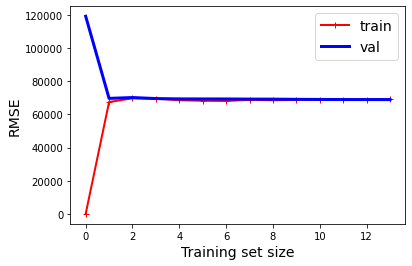

In [26]:
#linear regression learning curve
# plt.ylim(50_000,90_000)
plot_learning_curves(lin_reg, housing_prepared, housing_labels)
#save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()                                      # not shown

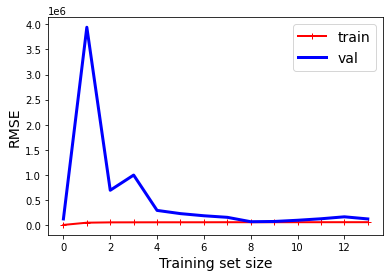

In [27]:
#polynomial regression learning curve
#trying code from page 133

# plt.ylim(50_000,90_000)
plot_learning_curves(poly_lin_reg, housing_poly, housing_labels)
#save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()                                      # not shown

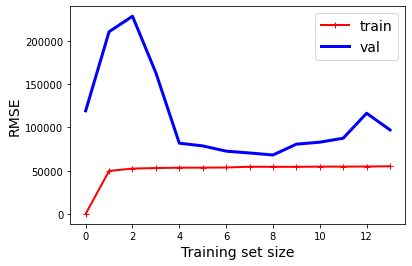

In [28]:
#ridge regression learning curve
# plt.ylim(50_000,90_000)
plot_learning_curves(ridge_reg, housing_poly, housing_labels)
#save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()                                      # not shown

# 4. Default dataset [17 marks]


In this question you will work with the Default dataset, which is a simulated dataset of credit card default for 10000 customers. Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/90503805/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf).

You want to predict credit card defaults. The target for this classification problem is `default` and all other variables are the features. 

## (a) [2 marks]
Load the dataset. If it is stored in a file named `Default.csv` in your working directory, this can be done with the code below. Then split the data into a training and a test set, using 20% of the data for the test set. When doing the splitting, use the random seed 42.

In [29]:
import os
os. chdir('C:\\Users\\olive\\OneDrive\\Documents\\AA UW CLASSES\\A A A Spring 2022 Classes\\CFRM 521\\Assignments')
data = pd.read_csv("Default.csv")

**[Add your solution here]**

In [30]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data,train_size = 0.2, random_state = 42)

In [31]:
data.head()

# data[data.isnull().any(axis=1)].shape #we have no null values (phew)
X_train = train_set.drop(["default"],axis=1)
y_train = train_set["default"].copy() #our targets

X_test = test_set.drop(["default"],axis=1)
y_test = test_set["default"].copy()

data_num = X_train.drop("student", axis=1)
data_cat = X_train["student"].copy()


In [32]:
# from sklearn.model_selection import train_test_split

# X = data.drop(["default"],axis=1)
# y = data["default"].copy()


# X_train, X_test, y_train, y_test = train_test_split(X, y ,train_size = 0.2, random_state = 42)

# data_num = X_train.drop("student", axis=1)
# data_cat = X_train["student"].copy()


## (b) [3 marks]

Design a pipeline for preprocessing that applies one hot encoding to the categorical features and a standard scaler to the numerical features.

**[Add your solution here]**

In [33]:
number_attribs = list(data_num)
categ_attribs = ["student"]

full_pipeline = ColumnTransformer([
    ("cat", OneHotEncoder(), categ_attribs),
    ("num", StandardScaler(), number_attribs),
])

data_prepared = full_pipeline.fit_transform(X_train) #notice we are only using the training set!


In [34]:
data_prepared

array([[ 1.        ,  0.        ,  0.77018151, -0.62394502],
       [ 1.        ,  0.        , -1.09121061, -0.11246274],
       [ 1.        ,  0.        , -0.9104332 ,  0.00676916],
       ...,
       [ 1.        ,  0.        , -0.23748237, -0.48924072],
       [ 0.        ,  1.        , -1.37290519, -0.92827081],
       [ 1.        ,  0.        , -0.40978481,  1.19755223]])

## (c) [4 marks]
Train a logistic regression classifier and a `SGDClassifier`, and then using 10-fold cross-validation plot the ROC curve of the classifiers and compute their ROC AUC.

**[Add your solution here]**

In [35]:
#logistic regression classifier
#creates binary classifiers
y_train_yes = (y_train == "Yes")
y_test_yes = (y_test=="Yes")

#reference code in ch4
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(data_prepared, y_train_yes)

LogisticRegression(random_state=42)

In [36]:
#Pg 52 of lec 4 notes
from sklearn.model_selection import cross_val_predict
y_log_scores = cross_val_predict(log_reg, data_prepared, y_train_yes, cv=10, method="decision_function")

#roc curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_yes, y_log_scores)

logistic


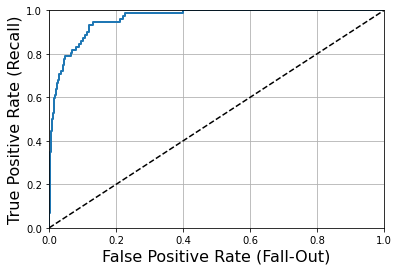

In [37]:
print("logistic")
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

# plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
# fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
# plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
# plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
# plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
# save_fig("roc_curve_plot")                                    # Not shown
plt.show()


In [38]:
#roc auc 
#ph 60 lec 4 notes

from sklearn.metrics import roc_auc_score

print("Logistic regression ROC AU score:")
roc_auc_score(y_train_yes, y_log_scores)

Logistic regression ROC AU score:


0.9610491585984324

In [39]:
#below is the SGD classifier

In [40]:
#pg 22 of lecture 4 notes
#creates binary classifiers

#create SGD classifier, pg 23 lec 4 notes
from sklearn.linear_model import SGDClassifier
import numpy as np

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(data_prepared,y_train_yes)

SGDClassifier(random_state=42)

In [41]:
#Pg 52 of lec 4 notes
from sklearn.model_selection import cross_val_predict
y_sgd_scores = cross_val_predict(sgd_clf, data_prepared, y_train_yes, cv=10, method="decision_function")

#roc curve
from sklearn.metrics import roc_curve

fpr1, tpr1, thresholds1 = roc_curve(y_train_yes, y_sgd_scores)

SGD Classifier


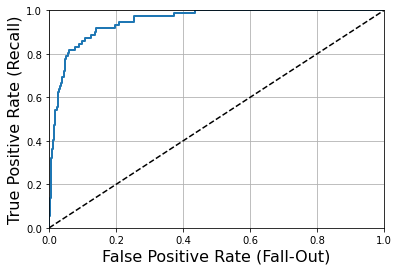

In [42]:
print("SGD Classifier")
def plot_roc_curve(fpr1, tpr1, label=None):
    plt.plot(fpr1, tpr1, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown


# plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr1, tpr1)
# fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
# plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
# plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
# plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
# save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [43]:
#roc auc 
#ph 60 lec 4 notes

from sklearn.metrics import roc_auc_score

print("SGD Classifier ROC AUC score:")
roc_auc_score(y_train_yes, y_sgd_scores)

SGD Classifier ROC AUC score:


0.9506252881512218

## (d) [5 marks]

For the classifiers in part (c), plot on the same axes the precision as a function of the threshold and the recall as a function of the threshold. Now suppose you want to achieve a recall of 80%. Consider 4 models:
 1.  The logistic regression classifier in (c),
 2. `SGDClassifier` in (c),
 3. A logistic regression with the argument `class_weight="balanced"`,
 4. `SGDClassifier` with the argument `class_weight="balanced"`.
 
For each of the 4 models, determine the threshold to achieve an 80% recall based on 10-fold cross-validation. Then determine the corresponding precisions. Which model has the best precision?

**[Add your solution here]**

In [44]:
from sklearn.metrics import precision_recall_curve #reference chapter 4 code
# i didn't use the correct scores for this part, reference pgs 44 and 45

precisions1, recalls1, thresholds1 = precision_recall_curve(y_train_yes, y_log_scores)
precisions2, recalls2, thresholds2 = precision_recall_curve(y_train_yes, y_sgd_scores)#did i use the correct scores here?

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.ylim([0,1])                            # Not shown

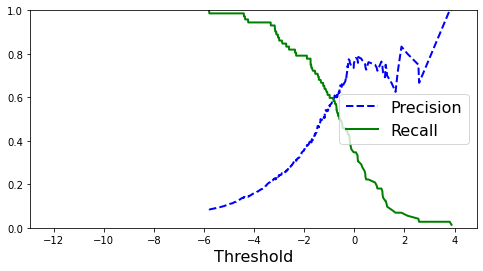

0.3118279569892473
0.8055555555555556
-2.324210336171485
Model 1
We'd want a decision threshold at around -2.323 to achieve a recall of 80% and a precision of 31%.
ROC AUC Score of:


In [46]:
#Part D
#we want to achieve a recall of 80%
#for classifier #1 (logisic regression in problem (c))
from sklearn.metrics import precision_score, recall_score

plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions1,recalls1,thresholds1)
plt.xlim([thresholds.min(), thresholds.max()])
plt.show()
y_log_scores = cross_val_predict(log_reg, data_prepared, y_train_yes, cv=10, method="decision_function") #log scores for training set
precisions1, recalls1, thresholds1 = precision_recall_curve(y_train_yes, y_log_scores)

threshold_precision = thresholds1[np.argmax(precisions1 >= 0.311)] #use code on page 96 of book
y_train_pred_prec = (y_log_scores >= threshold_precision) 

print(precision_score(y_train_yes, y_train_pred_prec))
print(recall_score(y_train_yes,y_train_pred_prec))
print(threshold_precision)

print("Model 1")
print("We'd want a decision threshold at around -2.323 to achieve a recall of 80% and a precision of 31%.")
print("ROC AUC Score of:")
# scores = log_reg.decision_function(data_test) #grabbed function from documentation

#grab the new log scores after finding desired recall level
# print("ROC AUC Score of:")
# scores = log_reg_c.decision_function(data_test) #grabbed function from documentation
# print(roc_auc_score(y_test_yes, scores))

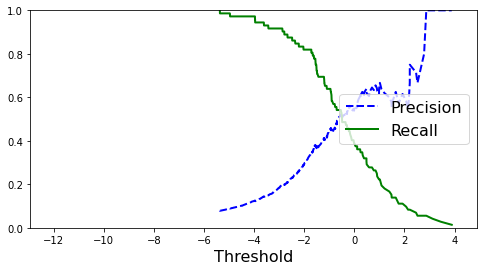

0.3515151515151515
0.8055555555555556
-1.6685561595326917
Model 2
We'd want a decision threshold at around -1.669 to achieve a recall of 80% and a precision of roughly 35%.


In [47]:
#for sgd classifier
y_sgd_scores = cross_val_predict(sgd_clf, data_prepared, y_train_yes, cv=10, method="decision_function")
precisions2, recalls2, thresholds2 = precision_recall_curve(y_train_yes, y_sgd_scores)

plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions2,recalls2,thresholds2)
plt.xlim([thresholds.min(), thresholds.max()])
plt.show()

#sets a new threshold value here
threshold_precision = thresholds2[np.argmax(precisions2 >= 0.35)] # np.argmin(recalls2 >= 0.8 works as well) use code on page 96 of book
y_train_pred_prec = (y_sgd_scores >= threshold_precision)

print(precision_score(y_train_yes, y_train_pred_prec))
print(recall_score(y_train_yes,y_train_pred_prec))
print(threshold_precision)

print("Model 2")
print("We'd want a decision threshold at around -1.669 to achieve a recall of 80% and a precision of roughly 35%.")
# print("ROC AUC Score of:")
# scores = sgd_clf.decision_function(data_test) #grabbed function from documentation
# print(roc_auc_score(y_test_yes, scores))

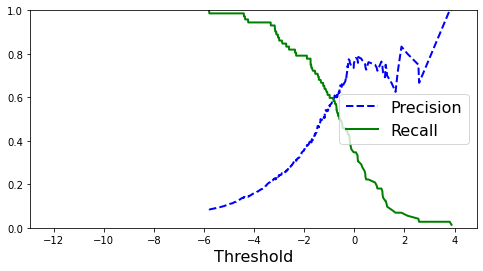

0.29
0.8055555555555556
0.7711335963421582
Model 3
We'd want a decision threshold at around 0.771 to achieve a recall of 80% and a precision of roughly 29%.


In [48]:
#model c (another log reg)
log_reg_c = LogisticRegression(solver="lbfgs", random_state=42, class_weight="balanced")
log_reg_c.fit(data_prepared, y_train_yes)

plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions1,recalls1,thresholds1)
plt.xlim([thresholds.min(), thresholds.max()])
plt.show()
y_log_scores = cross_val_predict(log_reg_c, data_prepared, y_train_yes, cv=10, method="decision_function")
precisions1, recalls1, thresholds1 = precision_recall_curve(y_train_yes, y_log_scores)


threshold_precision = thresholds1[np.argmax(precisions1 >= 0.29)] #use code on page 96 of book
y_train_pred_prec = (y_log_scores >= threshold_precision)

print(precision_score(y_train_yes, y_train_pred_prec))
print(recall_score(y_train_yes,y_train_pred_prec))
print(threshold_precision)

print("Model 3")
print("We'd want a decision threshold at around 0.771 to achieve a recall of 80% and a precision of roughly 29%.")

# print("ROC AUC Score of:")
# scores = log_reg_c.decision_function(data_test) #grabbed function from documentation
# print(roc_auc_score(y_test_yes, scores))


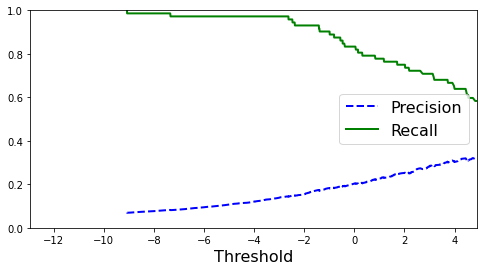

0.20567375886524822
0.8055555555555556
0.25392605593660633
We'd want a decision threshold at around 0.2539 to achieve a recall of 80% and a precision of roughly 20%.


In [49]:
#model d ( another SGD classifier )
sgd_clf_d = SGDClassifier(random_state=42, class_weight="balanced")
sgd_clf_d.fit(data_prepared,y_train_yes)

y_sgd_scores = cross_val_predict(sgd_clf_d, data_prepared, y_train_yes, cv=10, method="decision_function")
precisions2, recalls2, thresholds2 = precision_recall_curve(y_train_yes, y_sgd_scores)

plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions2,recalls2,thresholds2)
plt.xlim([thresholds.min(), thresholds.max()])
plt.show()

#set a new threshold value here
threshold_precision = thresholds2[np.argmax(precisions2 >= 0.205)] #use code on page 96 of book
y_train_pred_prec = (y_sgd_scores >= threshold_precision)

print(precision_score(y_train_yes, y_train_pred_prec))
print(recall_score(y_train_yes,y_train_pred_prec))
print(threshold_precision)


print("We'd want a decision threshold at around 0.2539 to achieve a recall of 80% and a precision of roughly 20%.")

# print("ROC AUC Score of:")
# scores = log_reg_c.decision_function(data_test) #grabbed function from documentation
# print(roc_auc_score(y_test_yes, scores))

In [50]:
print("Of the four models, model b, the SGD classifier from part c, has the best precision of 35%.")

Of the four models, model b, the SGD classifier from part c, has the best precision of 35%.


## (e) [3 marks]

Fit the best classifier in (d) to the whole training data, and use it to predict on the test set. What is its accuracy, precision, recall, ROC curve and ROC AUC over the test set?

**[Add your solution here]**

Stats over the test set
ROC CURVE


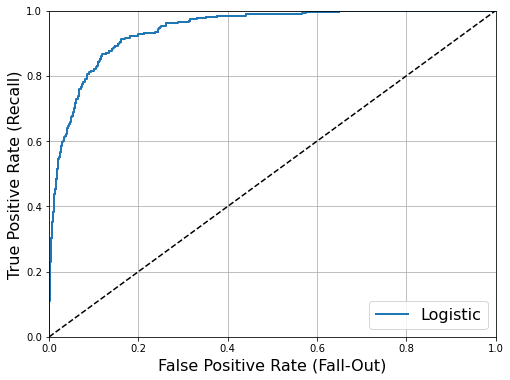

ROC AUC Score
0.9427015182592621
Precision Score
0.3504273504273504
Recall Score
0.6283524904214559
Accuracy
0.95825


In [51]:
data_test = full_pipeline.fit_transform(X_test) #notice we are only using the training set!

#use SGD classifier (model 2)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(data_prepared,y_train_yes)

#for ROC curve
scores = sgd_clf.decision_function(data_test) #grabbed function from documentation
precisions2, recalls2, thresholds2 = precision_recall_curve(y_test_yes, scores)

#sets a new threshold value here, this is from part d model 2
threshold_precision = thresholds2[np.argmax(precisions2 >= 0.35)] #use code on page 96 of book
y_test_pred_prec = (scores >= threshold_precision)





#pg 62
fpr, tpr, thresholds = roc_curve(y_test_yes,scores) #unaffected by change in threshold
print("Stats over the test set")
print("ROC CURVE")
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr,"b:", linewidth=2)
plot_roc_curve(fpr,tpr,"Logistic")
plt.legend(loc="lower right", fontsize=16)
plt.show()

#ROC AUC score
print("ROC AUC Score")
print(roc_auc_score(y_test_yes, scores))

#Precision Score
from sklearn.metrics import precision_score, recall_score
# pred = log_reg.predict(data_test)
print("Precision Score")
print(precision_score(y_test_yes, y_test_pred_prec))

#Recall Score
print("Recall Score")
print(recall_score(y_test_yes, y_test_pred_prec))

#Accuracy
print("Accuracy")
print(log_reg.score(data_test,y_test_pred_prec))

